# **KAIST EE**
#  **[EE488] note 04E. Slime Volleyball Agent Test**
## **Instructor**: Prof. Yoon, Young-Gyu (ygyoon@kaist.ac.kr)
### This example code was prepared by EE488 teaching assistants Han, Seungjae (jay0118@kaist.ac.kr) & Shin, Changyeop (scey26@kaist.ac.kr).

- Class Date : 22.03.xx.
- Office Hour : -----------
- If you have any questions, ask via KLMS Q&A board or come to TA office hour to get our help.

---

1. As usual, let's start with importing libraries!

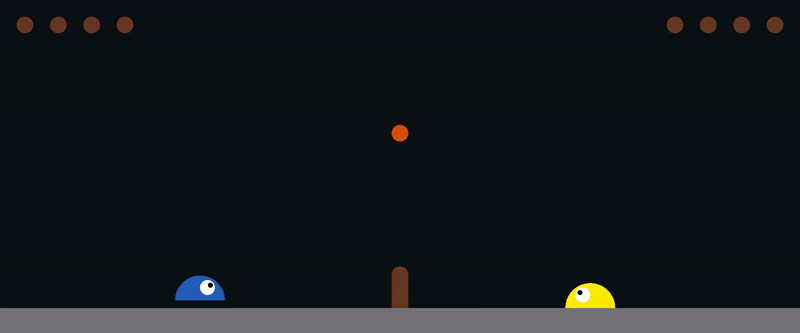

#<font color='red'> **CAUTION: DO NOT MODIFY ANY CODE EXCEPT CELL 8** </font>


### 1. Let's **mount Google drive** so that we can load files as we need.

In [18]:
from google.colab import drive
drive.mount("/content/drive")
import sys
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Let's Install **stable-baselines3** and **SlimeVolleyGym**.

In [19]:
!pip install slimevolleygym
!pip install stable-baselines3==1.4.0



### 3. Let's install a few more things to setup RL enviroment. 

In [20]:
# install required system dependencies
!apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

# Followings are for visualization (as we are running on server without a physical display!)
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

# Autoreload in case that the custom modules are changed
%load_ext autoreload
%autoreload 2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
The autoreload extension is already loaded. To reload it, us

### 4.  And then, let's **import the libraries** (including SlimeVolleyGym and stable-baselines3) we need to use.

In [21]:
import slimevolleygym
from slimevolleygym import FrameStack
import gym
import time
import torch
import base64

from stable_baselines3.common.atari_wrappers import ClipRewardEnv, NoopResetEnv, MaxAndSkipEnv, WarpFrame
from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import A2C, DQN, PPO, SAC
from stable_baselines3.common.vec_env import VecFrameStack

import cv2

import random

### 5. We need a bunch of stuff for **visualization** (as we are running on server without a physical display!). Let's not worry about the details here.

In [22]:
from stable_baselines3.common.monitor import Monitor
from gym.wrappers import Monitor as eval_Monitor
import matplotlib.pyplot as plt
import numpy as np
import glob
import io
import base64
from IPython.display import HTML, clear_output
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

display = Display(visible=0, size=(400, 300))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1005'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1005'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

### 6. Here's our function for visualization of the result as a **video**.

In [23]:
def show_video(episode, rnd):
  mp4list = glob.glob(f'video_{episode}_{rnd}/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    os.system(f"ffmpeg -i {mp4} -vcodec libx264 video_{episode}_{rnd}/compressed.mp4")
    video = io.open(f'video_{episode}_{rnd}/compressed.mp4', 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 200px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def wrap_env(env, episode, rnd):
    env = eval_Monitor(env, f'./video_{episode}_{rnd}', force=True)
    return env

###7. To make two agents play the game, we have to modify wrappers. Let's not worry about the details here.

In [24]:
class SlimeVolleyOpponentEnv(slimevolleygym.SlimeVolleyEnv):
    def __init__(self, opponent):
        super(SlimeVolleyOpponentEnv, self).__init__()
        self.policy = self
        self.opponent = opponent
        # self.otherAction = [0, 0, 0]

    def predict(self, obs):
        action, _ = self.opponent.predict(obs)
        return action
        
    def reset(self):
        return super(SlimeVolleyOpponentEnv, self).reset()


def make_env(seed, opponent):
    env = SlimeVolleyOpponentEnv(opponent=opponent)
    return env


def make_env_default(seed):
    env = gym.make("SlimeVolley-v0")
    return env        

### 8. Loading your agent.

Agents of stable baselines returns action from observation with `predict` function.

#### **IMPORTANT**
You will submit two files for tournnament.
- **This file (ipynb)** that includes the test log of your own agent.
- **Trained agent file (zip)**. The name should be `TeamX.zip`. X is the team number.

<br>
<hr>

<font color='black'>You have to make/modify a cell for loading your trained agent. </font>

<font color='black'> You should not modify any other cells. </font>

<font color='black'> The path will be changed to the path of TA's Google Drive. TA will upload pretrained .zip files at his Google Drive `/content/drive/My Drive/EE488_Colab/tournament/`.</font>

<font color='black'> The name of your agent should be `AgentX`. X is the team number. </font>

<font color='black'> Check your agent working well in this notebook, such as `predict` function. </font>


<hr>

#<font color='red'> **Your Agent: DO NOT MODIFY ANY CODE EXCEPT THIS CELL** </font>

In [33]:
# THIS CELL WILL BE USED IN TOURNAMENT, EXCEPT FILEPATH #
filepath = "/content/drive/My Drive/AIcapstone/RL/Tournament/trained_agent/trial_19/Volleyball_04/best_model.zip"
Agent1 = A2C.load(filepath)
# THIS CELL WILL BE USED IN TOURNAMENT, EXCEPT FILEPATH #

###9. Now, let's **evaluate** the performance of your agent. First, we will play against the default AI. 

In [34]:
# play against default AI
n_game = 1
init_seed = 5

cumulative_reward = 0
cumulative_win_str = []

print("Your Agent is on the right.\n")
print(f"      Enemy (blue) vs. You (yellow)")

for gi in range(n_game):
    env = make_env_default(init_seed)
    vid_name = f'against_default_ai_{gi}'
    rnd = random.randint(0, 1000)
    env = wrap_env(env, vid_name, rnd=rnd)

    obs1 = env.reset()

    done = False
    total_reward = 0

    while not done:
        action1, _ = Agent1.predict(obs1)
        obs1, reward, done, info = env.step(action1)
        total_reward += reward
        env.render()

    cumulative_reward += total_reward

    if total_reward > 0:
        win_str = 'You win!'
        cumulative_win_str.append('You')
    elif total_reward == 0:
        win_str = 'Draw'
        cumulative_win_str.append('Draw')
    else:
        win_str = 'You lose!'
        cumulative_win_str.append('Enemy')

    
    print(f"[{gi+1}th game]    {-total_reward}    :    {total_reward}    ||    {win_str}\n")

    env.close()
    show_video(vid_name, rnd=rnd)

print(f"\nResult : {cumulative_win_str}, Cumulative score : {cumulative_reward}")

Your Agent is on the right.

      Enemy (blue) vs. You (yellow)
[1th game]    -1    :    1    ||    You win!




Result : ['You'], Cumulative score : 1


10. In this part, you will let the agent play the game against itself. Let's see what happens.

In [35]:
n_game = 1
init_seed = 1234

cumulative_reward = 0
cumulative_win_str = []


print(f"            Blue vs. Yellow")
for gi in range(n_game):
    env = make_env(seed=init_seed + gi, opponent=Agent1)
    vid_name = f'your_agent_vs_your_agent_{gi}'
    rnd = random.randint(0, 1000)
    env = wrap_env(env, vid_name, rnd=rnd)

    obs1 = env.reset()

    done = False
    total_reward = 0

    while not done:
        action1, _ = Agent1.predict(obs1)
        obs1, reward, done, info = env.step(action1)
        total_reward += reward
        env.render()

    cumulative_reward += total_reward

    if total_reward > 0:
        win_str = 'Yellow (right) wins!'
        cumulative_win_str.append('Yellow (right)')
    elif total_reward == 0:
        win_str = 'Draw'
        cumulative_win_str.append('Draw')
    else:
        win_str = 'Blue (left) wins!'
        cumulative_win_str.append('Blue (left)')

    
    print(f"[{gi+1}th game]    {-total_reward}    :    {total_reward}    ||    {win_str}\n")

    env.close()
    show_video(vid_name, rnd=rnd)

print(f"\nResult : {cumulative_win_str}, Cumulative score : {cumulative_reward}")

            Blue vs. Yellow


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[1th game]    0    :    0    ||    Draw




Result : ['Draw'], Cumulative score : 0


11. In this part, we will simply evaluate the performance of your agent (against default AI) without visualization.

In [37]:
# play against default AI
n_game = 20
init_seed = 5

cumulative_reward = 0
cumulative_win_str = []

print("Your Agent is on the right.\n")
print(f"            Enemy vs.  You")
for gi in range(n_game):
    env = make_env_default(init_seed)
    vid_name = f'against_default_ai_{gi}'
    rnd = random.randint(0, 1000)

    obs1 = env.reset()

    done = False
    total_reward = 0

    while not done:
        action1, _ = Agent1.predict(obs1)
        obs1, reward, done, info = env.step(action1)
        total_reward += reward

    cumulative_reward += total_reward

    if total_reward > 0:
        win_str = 'You win!'
        cumulative_win_str.append('You')
    elif total_reward == 0:
        win_str = 'Draw'
        cumulative_win_str.append('Draw')
    else:
        win_str = 'You lose!'
        cumulative_win_str.append('Enemy')

    
    print(f"[{gi+1}th game]    {-total_reward}    :    {total_reward}    ||    {win_str}\n")

    env.close()

print(f"\nResult : {cumulative_win_str}, Cumulative score : {cumulative_reward}")

Your Agent is on the right.

            Enemy vs.  You
[1th game]    -1    :    1    ||    You win!

[2th game]    -1    :    1    ||    You win!

[3th game]    -1    :    1    ||    You win!

[4th game]    0    :    0    ||    Draw

[5th game]    -2    :    2    ||    You win!

[6th game]    -1    :    1    ||    You win!

[7th game]    0    :    0    ||    Draw

[8th game]    -1    :    1    ||    You win!

[9th game]    -1    :    1    ||    You win!

[10th game]    0    :    0    ||    Draw

[11th game]    0    :    0    ||    Draw

[12th game]    0    :    0    ||    Draw

[13th game]    1    :    -1    ||    You lose!

[14th game]    0    :    0    ||    Draw

[15th game]    0    :    0    ||    Draw

[16th game]    0    :    0    ||    Draw

[17th game]    -1    :    1    ||    You win!

[18th game]    -2    :    2    ||    You win!

[19th game]    -3    :    3    ||    You win!

[20th game]    0    :    0    ||    Draw


Result : ['You', 'You', 'You', 'Draw', 'You', 'You', 'Dr

### **Congratulations**! Now you are ready to submit your agent.

---